In [6]:

from cv_bridge import CvBridge, CvBridgeError
from sklearn.gaussian_process import GaussianProcessRegressor 
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages') # in order to import cv2 under python3
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages') # append back in order to import rospy
import rospy 
import message_filters
import argparse
from add_pts import PlanningGraph
from sensor_msgs.msg import Image
import path_plan as pp 
from sensor_msgs.msg import JointState
import numpy as np
import moveit_commander
import random
import threading 
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
from sklearn.gaussian_process.kernels import RBF

Using TensorFlow backend.


Failed to import pyassimp, see https://github.com/ros-planning/moveit/issues/86 for more info


In [2]:
def acquisition(m, s, scale=.3):
    #return m + scale * s 
    return m + .3*s

In [3]:
class ActivePlanner(object):

    def __init__(self, target_img, vfile, efile, robot, target_name, search_dist=1):
        self.target_img = target_img
        self.training_pts = []
        self.training_labels = []
        self.trajectory = []
        self.PG = PlanningGraph(vfile, efile, robot)
        self.search_dist = search_dist
        self.rewards = []
        self.target_name = target_name
        self.views = 0
        self.position = None

        self.next_view = None
        #self.image_topic = image_topic
        self.robot = robot

        if self.robot == "pr2":
            self.group_name = "left_arm"
        elif self.robot == "ur10":
            self.group_name = "blue_arm"
        else:
            print("robot name not valid")
            exit() 

        self.update = False
        #self.lock = threading.Lock()

        self.GP = GaussianProcessRegressor(kernel=RBF(0.3), alpha=0.001, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=True, copy_X_train=True, random_state=None)
        self.model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(480,640,3), pooling='avg', classes=1000)
        rospy.init_node('active_planner', anonymous=True)
        self.setInitialPose()

        self.graph = tf.get_default_graph()

    def setInitialPose(self, init_index=1):
        group = moveit_commander.MoveGroupCommander(self.group_name)

        wpose = group.get_current_pose().pose
        #print("wpose: " + str(wpose))
        #print(wpose.position)
        joint_vals = group.get_current_joint_values()

        #print("current joint vals" + str(joint_vals))
        nodes = self.PG.getNodes()

        #print("nodes" + str(nodes))
        #print("edges: " + str(self.PG.connections))
        cur_index, min_dist = self.PG.findClosestNode(joint_vals)
        current = self.PG.index2state(cur_index)
        #print("min dist to graph: " + str(min_dist))    

        #print("start at: " + str(current) + " index: " + str(cur_index))
        if init_index == None:
            index = random.randint(1, len(nodes) - 1)
        else:
            index = init_index
        print("initial index: " + str(index))
        pp.planAndExecuteFromWaypoints(current, nodes[index], self.PG, self.group_name, max_dist = .5)

    def run(self, num_views=20):



        if self.robot == "pr2":
            im_sub = message_filters.Subscriber("/l_forearm_cam/image_color", Image, queue_size=1)
            joints_sub = message_filters.Subscriber("/l_arm_controller/state", JointTrajectoryControllerState, queue_size=1) 
        elif self.robot == "ur10":
            im_sub = message_filters.Subscriber("/camera/color/image_raw", Image, queue_size=1)
            joints_sub = message_filters.Subscriber("/blue/joint_states", JointState, queue_size=1)
        else:
            print("robot name not valid")
            exit() 
        
        synched_sub = message_filters.ApproximateTimeSynchronizer([im_sub, joints_sub], queue_size=1, slop=0.05)
        synched_sub.registerCallback(self.callback)

        rate = rospy.Rate(10) # 10hz

        while not rospy.is_shutdown() and self.views <= num_views and self.views > 0:
            print("view: " + str(self.views))
            if self.update is True:
                self.cycleViews()
                #self.chooseNextView()


            rate.sleep()
            
    def cycleViews(self):
        position = self.position

        current_node, _ = self.PG.findClosestNode(position)
        print("at node: " + str(current_node))

        self.next_view = self.PG.index2state((current_node + 1) % len(self.PG.getNodes()))

        pp.planAndExecuteFromWaypoints(position, self.next_view, self.PG, self.group_name, max_dist = .5)
        self.views += 1
        self.update = False
        print("num views: " + str(self.views))

    def chooseNextView(self):
        # get candidate set using graph, train gp

	

        points = self.training_pts
        labels = self.training_labels
        position = self.position

        self.GP.fit(points, labels)
        current_index, _ = self.PG.findClosestNode(position)
        

        ### SAMPLE MPC
#         best_score, best_index = self.getMaxScore(current_index, depth=5)
#         best_view = self.PG.index2state(best_index)

#         self.trajectory.append(best_index)
#         print("current position: " + str(self.PG.findClosestNode(self.position)))
#         #print(str(self.GP.predict(self.PG.getNodes())))                                                                │[ INFO] [1573741907.605854638]: Solution found in 0.011575 seconds
#         #plt.plot(range(len(self.PG.getNodes())), self.GP.predict(self.PG.getNodes())[0]) 
        
        ####

        ### TRAJECTORY SAMPLING 
        sampleTs = self.sampleTrajectories(current_index)
        print("sampled trajectories: " + str(sampleTs))

        #samplePreds = [[self.GP.predict(self.PG.index2state(pts).reshape(1, -1), return_std=True) for pts in traj] for traj in sampleTs]
        destinations = [self.PG.index2state(traj[-1]) for traj in sampleTs] 
        samplePreds = self.GP.predict(destinations, return_std=True)
        samplePreds = zip(samplePreds[0], samplePreds[1])
        print("sample preds: " + str(samplePreds))

        #scores = [sum([acquisition(*pred) for pred in preds]) for preds in samplePreds]

        scores = [acquisition(*pred) for pred in samplePreds]        
        # print("training labels: " + str(self.training_labels))
        # means, stds = self.GP.predict(cand_pts, return_std=True)
        # print("means: " + str(means))

        #scores = [acquisition(m, s) for (m, s) in zip(means, stds)]
        print("scores: " + str(scores))
        best_index = np.argmax(np.array(scores))
        best_view = self.PG.index2state(sampleTs[best_index][-1])

        self.trajectory.append(sampleTs[best_index][-1])
        ####
        
        
        #### ALL WITHIN DIST
#         cand_pts = self.PG.getNodesWithinDist(current_index, 20)
#         preds = self.GP.predict([self.PG.index2state(n) for n in cand_pts], return_std=True)
#         scores = [acquisition(*pred) for pred in zip(preds[0], preds[1])] 
#         print("scores: " + str(scores))
#         best_index = cand_pts[np.argmax(np.array(scores))]
#         best_view = self.PG.index2state(best_index)
        ####
        
        means, stds = self.GP.predict(self.PG.getNodes(), return_std=True)
        pl.plot(range(len(self.PG.getNodes())), [acquisition(*pred) for pred in zip(means, stds)] )
        #pl.plot(range(len(self.PG.getNodes())), stds)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        
        print("best view: " + str(self.PG.findClosestNode(best_view)))
        pp.planAndExecuteFromWaypoints(position, best_view, self.PG, self.group_name, max_dist = .5)
        self.views += 1
	    
        self.update = False
        self.next_view = best_view

    def sampleTrajectories(self, node, num_t=10, depth=20):
        

        children = self.PG.getNodesWithinDist(node, 1)
        to_expand = [children[random.randint(0, len(children) - 1)] for c in range(num_t)]
        trajectories = [[t] for t in to_expand]

        i = 1
        while i < depth:
            i += 1
            children = [self.PG.getNodesWithinDist(c, 1) for c in to_expand]
            to_expand = [c[random.randint(0, len(c) - 1)] for c in children if len(c) > 0]

            for k in range(num_t):
                trajectories[k].append(to_expand[k])

        return trajectories

    def getMaxScore(self, node, depth=5, branch=4, fullFirstLayer=True):
        children = self.PG.getNodesWithinDist(node, 1)
        #print("children of {}: {}".format(node, children))
        if fullFirstLayer == True:
            to_expand = [children[random.randint(0, len(children) - 1)] for c in range(branch)]
        else:
            to_expand = children
            
        preds = self.GP.predict([self.PG.index2state(t) for t in to_expand], return_std=True)
        scores = [acquisition(*pred) for pred in zip(preds[0], preds[1])] 
        
        if depth == 1:
            return max(scores), to_expand[np.argmax(np.array(scores))]
            
        scores = [scores[i] + self.getMaxScore(to_expand[i], depth - 1, max(1, int(branch/2)), False)[0] for i in range(0, len(scores))]
        
        return max(scores), to_expand[np.argmax(np.array(scores))]


    def callback(self, img, joint_state): # use eef
	print("entering callback")
        cv_image = CvBridge().imgmsg_to_cv2(img, "bgr8")
        #cv2.imshow('im', cv_image)
        
        position = joint_state.position
        try:
            print(self.toFeatureRepresentation(self.target_img, (img.height, img.width, 3)))
            print(self.toFeatureRepresentation(cv_image, (img.height, img.width, 3)))
            #print("h,w: {}, {}".format(img.height, img.width))
            reward = self.imageCompare(self.toFeatureRepresentation(cv_image, (img.height, img.width, 3))) - 1
            print("reward: " + str(reward))

            self.training_pts.append(position)
            self.training_labels.append(reward)
       
        except ValueError:
            print("something isn't working right")
            reward = None
            print(self.toFeatureRepresentation(self.target_img, (img.height, img.width, 3)))
        #finally:


        if len(self.training_pts) > 1000:
            index = random.randint(0, len(self.training_pts) - 1)
            self.training_pts.pop(index)
            self.training_labels.pop(index)

        #print("training labels: {}".format(self.training_labels))
        self.position = position

        if reward is not None and (self.next_view is None or np.linalg.norm(np.array(position) - np.array(self.next_view)) < .1):
            self.rewards.append(reward)
            self.update = True
            print("trajectory: {}".format(self.trajectory))
            #print("rewards: {}".format(self.rewards))
            #print("trajectory: {}".format(self.trajectory))
            #self.next_view = self.chooseNextView(position)
            #self.views += 1

    def toFeatureRepresentation(self, img, img_shape=(480,640,3)):
        img = np.expand_dims(img, axis=0)
        print(np.shape(img))
        with self.graph.as_default():
            return np.array(self.model.predict(img)).flatten()


    def imageCompare(self, img):
        target = self.toFeatureRepresentation(self.target_img)

        return np.dot(target, img)/(np.linalg.norm(target) * np.linalg.norm(img))

    def saveRewards(self, fname):
        print("saving rewards in: " + str(fname))
        rewards = [str(tl) for tl in self.rewards]
        print("rewards: {}, array: {}".format(",".join(rewards), self.rewards))
        with open(self.target_name + "_rewards.2.csv", "ab") as f:
           f.write(",".join(rewards) + "\n")
        with open(self.target_name + "_trajectory.2.csv", "ab") as f:
           f.write(",".join(str(self.trajectory)) + "\n")
        #np.save(fname, np.array(self.training_labels))

    def reset(self, saveTrajectory=False):
        print("resetting")
        #with self.lock:
        print("trajectory: {}".format(self.trajectory))
        self.trajectory = []
        self.training_pts = []
        self.training_labels = []
        self.next_view = None 
        self.views = 0
        self.GP = GaussianProcessRegressor(kernel=None, alpha=0.001, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=True, copy_X_train=True, random_state=None)
        self.saveRewards("rewards_{}.csv".format(self.target_name))
        if saveTrajectory == True:
            np.save("trajectory_{}.npy".format(self.target_name), self.training_pts)
        self.rewards = []
        
        
        



In [4]:
if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("--vfile", default="test_graph_pts.npy", help="File path for saving vertices")
    parser.add_argument("--efile", default="test_graph_edges.npy", help="File path for saving edges")
    parser.add_argument("--robot_name", default="ur10", help="Name of robot")
    args, unknown_args = parser.parse_known_args()

    targets = ['liquid.jpg'] #, 'left0000.jpg']
    target_names = ['liquid'] #, 'torso']

    num_views = 30
    num_trials = 1

    for t, n in zip(targets, target_names):
        print("t, n: {}, {}".format(t, n))
        # send to initial position
        target_im = cv2.imread(t)
        #print(np.shape(np.array(target_im)))
        #print(target_im)
        cv2.imshow('target', target_im)
        ap = ActivePlanner(target_im, args.vfile, args.efile, args.robot_name, n)

        for i in range(0, num_trials):
            print("trial: " + str(i))
            ap.run(num_views)
            ap.reset()

t, n: liquid.jpg, liquid
test_graph_pts.npy








initial index: 1
trial: 0
resetting
trajectory: []
saving rewards in: rewards_liquid.csv
rewards: , array: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.35548466 0.32121068 0.08171115 ... 0.         0.01364894 0.25198254]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07258027791976929
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.31450465 0.39747927 0.08997853 ... 0.         0.00445703 0.2627866 ]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07462793588638306
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.3208049  0.3688387  0.09438971 ... 0.         0.00805323 0.29940236]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07512730360031128
trajectory: []
entering callbac

reward: -0.07579004764556885
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.3103127  0.3782469  0.06634074 ... 0.         0.00498004 0.53036636]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07584226131439209
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.2935227  0.38098997 0.06261178 ... 0.         0.01318997 0.5532325 ]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07574611902236938
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.30837697 0.37409866 0.06006337 ... 0.         0.00457998 0.50515383]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07635247707366943
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.3338696

(1, 480, 640, 3)
reward: -0.07477468252182007
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.37791315 0.402176   0.09354366 ... 0.         0.00947283 0.26552173]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.074138343334198
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.3725458  0.36992896 0.08142175 ... 0.         0.01370933 0.2732553 ]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07345998287200928
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.3735787  0.38225502 0.0975103  ... 0.         0.01485446 0.27505583]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.073391854763031
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 

reward: -0.07607460021972656
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.31780496 0.39521447 0.05380574 ... 0.         0.00429224 0.47880298]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.0759400725364685
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.29595593 0.37352556 0.06223761 ... 0.         0.00093528 0.5259425 ]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07601875066757202
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.30755478 0.40766683 0.05780667 ... 0.         0.00823951 0.5691616 ]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07675915956497192
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.28446892

(1, 480, 640, 3)
reward: -0.0763818621635437
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.31605664 0.36099142 0.06410044 ... 0.         0.0023207  0.57872796]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07658720016479492
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.31552577 0.3843106  0.06062311 ... 0.         0.00570687 0.43876955]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07622593641281128
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.31358176 0.40231398 0.06201899 ... 0.         0.00624599 0.36108127]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07543128728866577
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 64

(1, 480, 640, 3)
reward: -0.07029485702514648
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.2792704  0.41968507 0.1188032  ... 0.         0.00500206 0.05722176]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07099884748458862
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.25589043 0.39882934 0.1162324  ... 0.         0.00582328 0.04469096]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07120382785797119
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 640, 3)
[0.31086856 0.35907054 0.10969259 ... 0.         0.00317555 0.11898907]
(1, 480, 640, 3)
(1, 480, 640, 3)
reward: -0.07025259733200073
trajectory: []
entering callback
(1, 480, 640, 3)
[3.3285823  2.5379539  0.24384288 ... 0.         0.         3.369376  ]
(1, 480, 6

In [2]:
rewards = [0.47662806510925293,0.47974294424057007,0.48192495107650757,0.48384296894073486,0.4783817529678345,0.47700440883636475,0.47661393880844116,0.46492719650268555,0.45186787843704224,0.38791555166244507,0.43389010429382324,0.4648575782775879,0.4629361629486084,0.4648311734199524,0.46390050649642944,0.4621341824531555,0.46638011932373047,0.4653688073158264,0.4421807527542114,0.4260711073875427,0.447226881980896,0.45407986640930176,0.46610957384109497,0.47398924827575684,0.47139596939086914,0.4455021619796753,0.4597364664077759,0.4759286642074585,0.4758448600769043,0.4541158676147461,0.4566347599029541,0.4125111699104309,0.43638139963150024,0.43645721673965454,0.41094970703125,0.39308881759643555,0.465320885181427,0.438351035118103,0.48023778200149536,0.4833310842514038,0.4630689024925232,0.46075546741485596,0.4727417230606079,0.4110891819000244,0.3885258436203003,0.4189252257347107,0.4677838683128357,0.46382367610931396,0.3758853077888489,0.4687918424606323,0.4441266655921936,0.44693851470947266,0.44667142629623413,0.4075852632522583,0.47191232442855835,0.45739781856536865,0.4521346688270569,0.4563484787940979,0.46415483951568604,0.4692356586456299,0.4685540795326233,0.4727250933647156,0.4660820960998535,0.4615175724029541,0.47429436445236206,0.45705389976501465,0.46602684259414673,0.4177033305168152,0.429973840713501,0.4203064441680908,0.4095020890235901,0.39960014820098877,0.4343299865722656,0.45951586961746216,0.47233784198760986,0.4735071659088135,0.46081340312957764,0.4085412621498108,0.4045526385307312,0.4024932384490967,0.46110010147094727,0.45035672187805176,0.4696037173271179,0.46205854415893555,0.4732181429862976,0.4677807688713074,0.44936007261276245,0.43925583362579346,0.4201100468635559,0.43774938583374023]

90

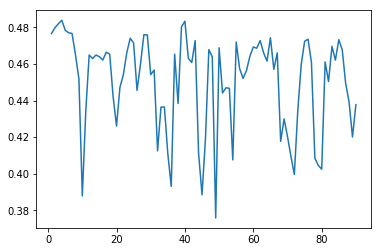

In [8]:
plt.plot(range(1, 91), rewards)

In [7]:
pink_hits = [2, 3, 41,50, 62, 63, 64,65, 87]
pink_hit_reward = [rewards[i] for i in range(0, 90) if i+1 in pink_hits]
pink_miss_reward = [rewards[i] for i in range(0, 90) if i+1 not in pink_hits]

hits = [32,33,34, 35,36, 37, 43, 44,45,46,47, 48, 53,54,55,56,57, 58, 91]

liquid[49]
#np.argmax(np.array(rewards))

NameError: name 'liquid' is not defined

In [18]:
rewards[40]

0.4630689024925232

(array([1., 0., 0., 1., 1., 2., 0., 2., 0., 2.]),
 array([0.44936007, 0.45261656, 0.45587305, 0.45912954, 0.46238602,
        0.46564251, 0.468899  , 0.47215549, 0.47541198, 0.47866846,
        0.48192495]),
 <a list of 10 Patch objects>)

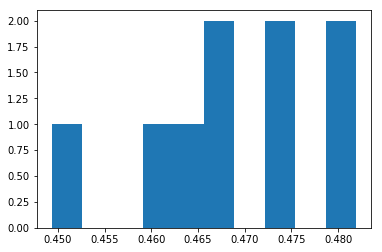

In [8]:
plt.hist(pink_hit_reward)

(array([ 1.,  3.,  4.,  7.,  3.,  8.,  7., 15., 21., 12.]),
 array([0.37588531, 0.38668107, 0.39747684, 0.40827261, 0.41906837,
        0.42986414, 0.4406599 , 0.45145567, 0.46225144, 0.4730472 ,
        0.48384297]),
 <a list of 10 Patch objects>)

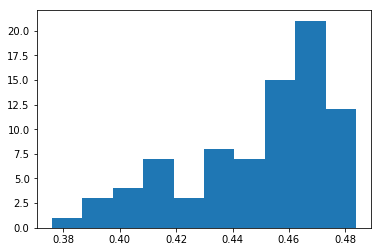

In [9]:
plt.hist(pink_miss_reward)

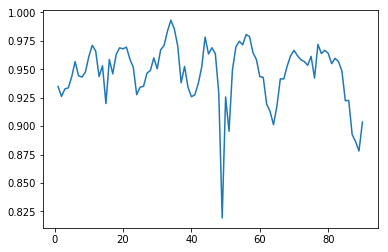

In [22]:
liquid = [0.9349127, 0.9261307, 0.9326553, 0.93373615, 0.94345146, 0.9568127, 0.9442604, 0.9432028, 0.9476003, 0.9611836, 0.97115695, 0.96616846, 0.94364506, 0.95309657, 0.91990584, 0.9586449, 0.94600606, 0.96312064, 0.9689192, 0.968031, 0.96955526, 0.9590254, 0.951792, 0.92767686, 0.9342841, 0.93501693, 0.9465943, 0.9489816, 0.9600702, 0.95050424, 0.9670825, 0.9709409, 0.9835836, 0.99317575, 0.985607, 0.97055215, 0.9381429, 0.9525537, 0.9342815, 0.9258478, 0.9275856, 0.9374475, 0.9517646, 0.97833973, 0.9634628, 0.96899, 0.9636619, 0.92904085, 0.81925535, 0.92569286, 0.89546466, 0.949653, 0.96964055, 0.9747052, 0.971566, 0.9806037, 0.978707, 0.9646452, 0.958615, 0.9435632, 0.94290936, 0.9193683, 0.91292936, 0.90128314, 0.9175561, 0.9415782, 0.9415327, 0.9528836, 0.9618784, 0.9667164, 0.9620377, 0.95848864, 0.95691836, 0.95349604, 0.961402, 0.9423476, 0.971883, 0.96389544, 0.9667551, 0.9640718, 0.9549891, 0.9596874, 0.9568384, 0.9486269, 0.9223796, 0.9226628, 0.89262956, 0.88639647, 0.87816215, 0.9035204]
plt.plot(range(1, 91), liquid)

t_liquid = [-1 * np.log(1 - x) for x in liquid]
t_liquid
hit_reward = [liquid[i] for i in range(0, 90) if i+1 in hits]
miss_reward = [liquid[i] for i in range(0, 90) if i+1 not in hits]


(array([1., 1., 0., 1., 0., 3., 5., 3., 3., 1.]),
 array([0.92904085, 0.93545434, 0.94186783, 0.94828132, 0.95469481,
        0.9611083 , 0.96752179, 0.97393528, 0.98034877, 0.98676226,
        0.99317575]),
 <a list of 10 Patch objects>)

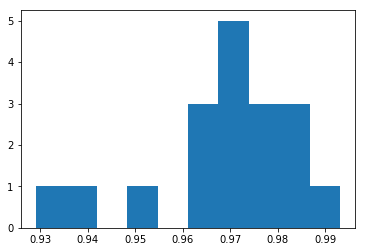

In [24]:
plt.hist(hit_reward)

(array([ 1.,  0.,  0.,  1.,  3.,  2.,  8., 10., 22., 25.]),
 array([0.81925535, 0.83451812, 0.84978088, 0.86504365, 0.88030641,
        0.89556918, 0.91083194, 0.92609471, 0.94135747, 0.95662024,
        0.971883  ]),
 <a list of 10 Patch objects>)

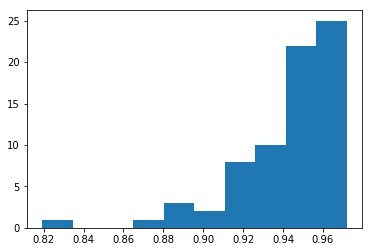

In [25]:
plt.hist(miss_reward)

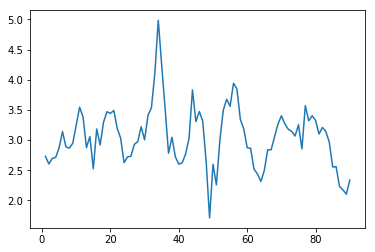

In [58]:
plt.plot(range(1, 91), t_liquid)

In [57]:

np.argmax(np.array(t_liquid))

33

In [18]:
liquid[26]

0.9465943

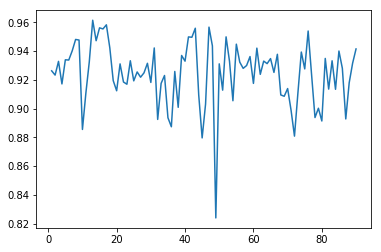

In [14]:
#11-18, 74-78

torso = [0.92622066, 0.9232572, 0.93278295, 0.9171087, 0.9338784, 0.9337217, 0.94007075, 0.9480325, 0.9476231, 0.8854536, 0.91069096, 0.9324628, 0.9613871, 0.9471552, 0.9561089, 0.9553464, 0.9581989, 0.94219226, 0.9194018, 0.9123462, 0.93104047, 0.91844344, 0.9168913, 0.93321913, 0.919239, 0.9254331, 0.92178965, 0.9248166, 0.93145424, 0.9181465, 0.94211334, 0.8924292, 0.9174599, 0.922976, 0.89360625, 0.8873189, 0.9257767, 0.9008413, 0.9368857, 0.9329317, 0.9497874, 0.94955844, 0.955829, 0.90941393, 0.879569, 0.9030754, 0.95659256, 0.94355804, 0.8239393, 0.9310572, 0.91277915, 0.9498319, 0.9328688, 0.9054147, 0.94475245, 0.9322588, 0.92793274, 0.9299011, 0.93613863, 0.91747886, 0.9419852, 0.9237691, 0.93297935, 0.9312282, 0.93472034, 0.9251139, 0.9377155, 0.9094468, 0.9085315, 0.9138867, 0.8988465, 0.8808068, 0.91070354, 0.9392717, 0.92754877, 0.9538969, 0.92361987, 0.8937302, 0.900197, 0.8913379, 0.9348292, 0.91351306, 0.93319446, 0.9133691, 0.9399764, 0.92795086, 0.89275295, 0.9179199, 0.93150604, 0.9414295]
plt.plot(range(1, 91), torso)